In [1]:
from typing import Dict, Tuple
import pandas as pd

from utils.error_metrics import MulticlassErrorMetrics, DatasetCategory

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


def get_set_with_dependend_variabels(
    df_set: pd.DataFrame, df_dependent
) -> pd.DataFrame:
    df = df_set[
        ["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
    ].copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df_dependent["Date"] = pd.to_datetime(df_dependent["Date"]).dt.date
    df = df.merge(df_dependent, on=["Date", "Area"])
    return df


def xy_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return (
        df.drop(
            columns=["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
        ),
        df_train["mapped_hazard_forecast"],
    )


def fit_and_compute_errors(
    errs: MulticlassErrorMetrics,
    independent_variables_and_sets: Tuple[str, Dict[DatasetCategory, pd.DataFrame]],
    model_name_and_pipeline: Tuple[str, Pipeline],
):
    independent_variables = independent_variables_and_sets[0]
    sets = independent_variables_and_sets[1]
    model_name = model_name_and_pipeline[0]
    pipe = model_name_and_pipeline[1]

    training_set = sets[DatasetCategory.TRAINING]
    x, y = xy_split(training_set)
    pipe.fit(x, y)

    for ds_type, ds in sets.items():
        x, _ = xy_split(ds)
        errs.compute_errors(model_name, independent_variables, ds_type, pipe.predict(x))


df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)
df_dev = pd.read_csv("../data/processed/SAIS_dev.csv", index_col=0)
df_test = pd.read_csv("../data/processed/SAIS_test.csv", index_col=0)
df_train_tab = pd.read_csv("../data/processed/SAIS_train_tabularised.csv", index_col=0)
df_dev_tab = pd.read_csv("../data/processed/SAIS_dev_tabularised.csv", index_col=0)
df_test_tab = pd.read_csv("../data/processed/SAIS_test_tabularised.csv", index_col=0)

df_weather_data_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_days_tabularised.csv"
)
df_weather_data_48h_then_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_tabularised_48_hours_then_days.csv"
)

snowprofiles = (
    "snow profiles",
    {
        DatasetCategory.TRAINING: df_train,
        DatasetCategory.DEVELOPMENT: df_dev,
        DatasetCategory.TEST: df_test,
    },
)

snowprofiles_whole_season = (
    "snow profiles across season",
    {
        DatasetCategory.TRAINING: df_train_tab,
        DatasetCategory.DEVELOPMENT: df_dev_tab,
        DatasetCategory.TEST: df_test_tab,
    },
)

weather_daily_whole_season = (
    "weather daily data across season",
    {
        DatasetCategory.TRAINING: get_set_with_dependend_variabels(
            df_train, df_weather_data_daily_tab
        ),
        DatasetCategory.DEVELOPMENT: get_set_with_dependend_variabels(
            df_dev, df_weather_data_daily_tab
        ),
        DatasetCategory.TEST: get_set_with_dependend_variabels(
            df_test, df_weather_data_daily_tab
        ),
    },
)

weather_48h_then_daily_season = (
    "weather 48h hourly then daily data across season",
    {
        DatasetCategory.TRAINING: get_set_with_dependend_variabels(
            df_train, df_weather_data_48h_then_daily_tab
        ),
        DatasetCategory.DEVELOPMENT: get_set_with_dependend_variabels(
            df_dev, df_weather_data_48h_then_daily_tab
        ),
        DatasetCategory.TEST: get_set_with_dependend_variabels(
            df_test, df_weather_data_48h_then_daily_tab
        ),
    },
)

In [2]:
most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

errs_summary = MulticlassErrorMetrics(
    dataset_name="sais",
    classes=sorted(df_train["mapped_hazard_forecast"].unique()),
    y_true_train=df_train["mapped_hazard_forecast"],
    y_true_dev=df_dev["mapped_hazard_forecast"],
    y_true_test=df_test["mapped_hazard_forecast"],
)

run = lambda model, data: fit_and_compute_errors(
    errs=errs_summary,
    independent_variables_and_sets=data,
    model_name_and_pipeline=model,
)

model_name_const = "const"
errs_summary.compute_errors_all_sets(
    model_name_const,
    None,
    most_frequent_value,
    most_frequent_value,
    most_frequent_value,
)
model_name_obs = "observed"
errs_summary.compute_errors_all_sets(
    model_name_obs,
    None,
    df_train["mapped_hazard_observed"],
    df_dev["mapped_hazard_observed"],
    df_test["mapped_hazard_observed"],
)

scaler = StandardScaler()
softmax = (
    "softmax",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1, max_iter=int(1e4))),
        ]
    ),
)

random_forest = (
    "random forest",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", RandomForestClassifier(random_state=1)),
        ]
    ),
)

cnn = (
    "CNN",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", MLPClassifier(random_state=1, max_iter=1000)),
        ]
    ),
)

In [3]:
run(softmax, snowprofiles)

run(softmax, snowprofiles_whole_season)

run(softmax, weather_daily_whole_season)

run(softmax, weather_48h_then_daily_season)

run(random_forest, weather_48h_then_daily_season)

run(cnn, weather_48h_then_daily_season)
# errs_summary.save_assets()

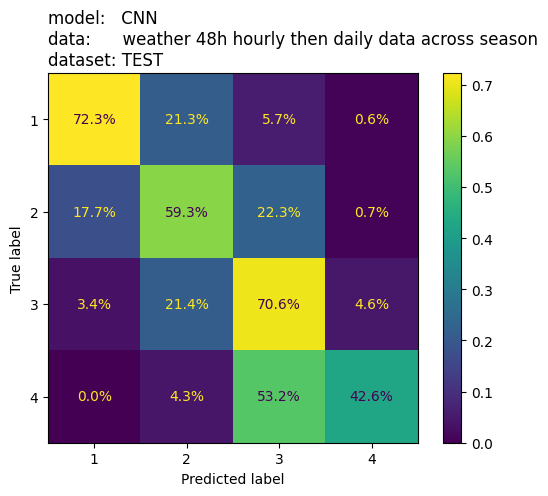

In [8]:
errs_summary.show_confusion_matrix(
    model_name=cnn[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

In [5]:
run(cnn, weather_48h_then_daily_season)

In [6]:
errs_summary.get_error_table_for_set(DatasetCategory.TEST)[-2:]

,MSE,average error,highest error,accuracy,precision (multiclass),precision (micro),precision (macro),recall (multiclass),recall (micro),recall (macro),$F_1$ (multiclass),$F_1$ (micro),$F_1$ (macro),confusion matrix
"random forest, weather 48h hourly then daily data across season",0.405488,0.031504,3,0.684959,"[0.79, 0.6, 0.65, 0.88]",0.684959,0.729059,"[0.82, 0.54, 0.77, 0.15]",0.684959,0.56878,"[0.8, 0.57, 0.71, 0.25]",0.684959,0.582901,"[[0.8152866242038217, 0.12738853503184713, 0.0..."
"CNN, weather 48h hourly then daily data across season",0.453252,-0.022358,-3,0.663618,"[0.78, 0.56, 0.67, 0.51]",0.663618,0.632684,"[0.72, 0.59, 0.71, 0.43]",0.663618,0.611919,"[0.75, 0.58, 0.69, 0.47]",0.663618,0.620829,"[[0.7229299363057324, 0.21337579617834396, 0.0..."
